In [152]:
import numpy as np
import pandas as pd
import copy

import torch
from torch import nn
from torch.utils.data import DataLoader,Dataset
from torchvision.models.detection import transform
from torchvision.transforms import transforms
from torchvision.datasets import ImageFolder
from torch.nn.functional import max_pool2d
import torch.nn.functional as F
import torch.optim as optim
from torchvision.transforms import RandomChoice

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

In [153]:
batch_size = 32
epochs_number = 100
patience = 5

In [154]:
#Create dataset
class PlayingCardDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data = ImageFolder(data_dir, transform=transform)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]
    
    @property
    def classes(self):
        return self.data.classes

In [155]:
#Model
class CardClassifier(nn.Module):
    def __init__(self, num_classes=53):
        super(CardClassifier,self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 16 * 16, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, num_classes)
        self.dropout1 = nn.Dropout(p=0.1)
        self.dropout2 = nn.Dropout(p=0.2)
        self.dropout3 = nn.Dropout(p=0.3)
         
    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = F.relu(self.fc3(x))
        x = self.dropout3(x)
        output = self.fc4(x)
        
        return output

In [156]:
model = CardClassifier(num_classes=53)
print(model)

CardClassifier(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=32768, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=53, bias=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.2, inplace=False)
  (dropout3): Dropout(p=0.3, inplace=False)
)


In [157]:
#Loss Function
criterion = nn.CrossEntropyLoss()
#Optimizer
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)

In [158]:
transform_train = transforms.Compose([
    transforms.Resize((128, 128)),
    RandomChoice([
        transforms.RandomHorizontalFlip(p=1.0),
        transforms.RandomVerticalFlip(p=1.0),
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.2)
    ]),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform = transforms.Compose([
    transforms.Resize((128, 128)), #Resize to 128x128
    transforms.ToTensor(), 
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_folder = r'C:\Users\piotr\Desktop\data\train'
valid_folder = r'C:\Users\piotr\Desktop\data\valid'
test_folder = r'C:\Users\piotr\Desktop\data\test'

train_dataset = PlayingCardDataset(train_folder, transform=transform_train)
val_dataset = PlayingCardDataset(valid_folder, transform=transform)
test_dataset = PlayingCardDataset(test_folder, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [159]:
# Early stopping

class EarlyStopping:
    def __init__(self, patience=5, min_delta=0, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_model = None
        self.best_loss = float('inf')
        self.counter = 0
        self.status = ""

    def __call__(self, model, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.best_model = copy.deepcopy(model.state_dict())
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.status = "Stopping training"
                if self.restore_best_weights:
                    model.load_state_dict(self.best_model)
                return True
        self.status = f"{self.counter}/{self.patience}"
        return False

In [160]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [161]:
num_epochs = epochs_number
train_losses, val_losses = [], []

model = CardClassifier(num_classes=53)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-3)
es = EarlyStopping(patience=patience)

epoch = 0
done = False
while epoch < num_epochs and not done:
    epoch += 1
    # Training phase
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc='Training loop'):
        # Move inputs and labels to the device
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)
    
    # Validation phase
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc='Validation loop'):
            # Move inputs and labels to the device
            images, labels = images.to(device), labels.to(device)
         
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)
    val_loss = running_loss / len(val_loader.dataset)
    val_losses.append(val_loss)
    print(f"Epoch {epoch}/{num_epochs} - Train loss: {train_loss}, Validation loss: {val_loss}")
    
     # Check early stopping criteria
    done = es(model, val_loss)
    print(f"Early Stopping: {es.status}")

Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 1/100 - Train loss: 3.74894068223607, Validation loss: 2.671394161008439
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 2/100 - Train loss: 2.8562156401050802, Validation loss: 2.0867845562269105
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 3/100 - Train loss: 2.4178751278023656, Validation loss: 1.7801240745580422
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 4/100 - Train loss: 2.2292228620675276, Validation loss: 1.6422078335060264
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 5/100 - Train loss: 2.0984474109077254, Validation loss: 1.5001343344742397
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 6/100 - Train loss: 1.9862378866950212, Validation loss: 1.477970790863037
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 7/100 - Train loss: 1.9013968103204668, Validation loss: 1.3585547969026386
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 8/100 - Train loss: 1.8064554176700829, Validation loss: 1.2625010575888291
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 9/100 - Train loss: 1.6962653982676839, Validation loss: 1.194817279419809
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 10/100 - Train loss: 1.5676575405024782, Validation loss: 1.0162868922611452
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 11/100 - Train loss: 1.441883031118579, Validation loss: 0.9461895065487556
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 12/100 - Train loss: 1.3550250290073103, Validation loss: 0.8847003689352072
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 13/100 - Train loss: 1.2514034639750797, Validation loss: 0.7037273209050017
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 14/100 - Train loss: 1.1622545705387, Validation loss: 0.6494632046177702
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 15/100 - Train loss: 1.0999460071481664, Validation loss: 0.6389052148135204
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 16/100 - Train loss: 1.0174390160149318, Validation loss: 0.6493112645059261
Early Stopping: 1/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 17/100 - Train loss: 0.952348638431473, Validation loss: 0.6086219357994368
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 18/100 - Train loss: 0.9029785682997449, Validation loss: 0.5649612267062349
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 19/100 - Train loss: 0.8528997213868004, Validation loss: 0.5817703460747341
Early Stopping: 1/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 20/100 - Train loss: 0.8010517258396429, Validation loss: 0.5490992334653746
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 21/100 - Train loss: 0.7419450854704738, Validation loss: 0.5132193621599449
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 22/100 - Train loss: 0.6794434134757531, Validation loss: 0.5123571062987705
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 23/100 - Train loss: 0.6595640495841676, Validation loss: 0.4749412499508768
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 24/100 - Train loss: 0.6365847012804038, Validation loss: 0.5084659490945205
Early Stopping: 1/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 25/100 - Train loss: 0.5947960323702001, Validation loss: 0.5514658484818801
Early Stopping: 2/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 26/100 - Train loss: 0.5886499954608405, Validation loss: 0.4071224915531446
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 27/100 - Train loss: 0.5483708198398258, Validation loss: 0.3754956924690391
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 28/100 - Train loss: 0.5327008732038493, Validation loss: 0.4558816486934446
Early Stopping: 1/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 29/100 - Train loss: 0.5067607601879777, Validation loss: 0.4043449029607593
Early Stopping: 2/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 30/100 - Train loss: 0.48263465451293575, Validation loss: 0.47572250900403507
Early Stopping: 3/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 31/100 - Train loss: 0.46189693704732193, Validation loss: 0.37118378090408616
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 32/100 - Train loss: 0.44027265612376076, Validation loss: 0.34729173520825946
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 33/100 - Train loss: 0.4149918246932195, Validation loss: 0.3941347565853371
Early Stopping: 1/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 34/100 - Train loss: 0.39753086244196856, Validation loss: 0.3705909175692864
Early Stopping: 2/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 35/100 - Train loss: 0.37792716786296643, Validation loss: 0.3147875751526851
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 36/100 - Train loss: 0.3776337264060724, Validation loss: 0.29979644833870656
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 37/100 - Train loss: 0.3347284672205246, Validation loss: 0.3247628350584012
Early Stopping: 1/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 38/100 - Train loss: 0.3371311335942678, Validation loss: 0.3594423756284534
Early Stopping: 2/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 39/100 - Train loss: 0.32119190775772705, Validation loss: 0.3466237562444975
Early Stopping: 3/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 40/100 - Train loss: 0.3067495964881881, Validation loss: 0.3688951391094136
Early Stopping: 4/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 41/100 - Train loss: 0.29699318494026206, Validation loss: 0.34040706202668963
Early Stopping: Stopping training


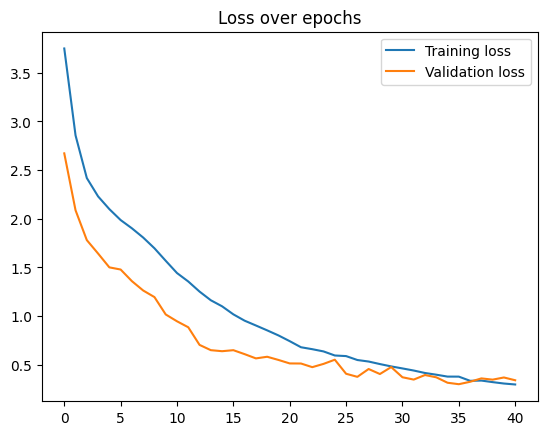

In [162]:
#Visualize Losses

plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()

In [163]:
# Calculate the Accuracy of the Model using test data

model.eval()
true_labels = []
predicted_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)  # Get the class index with the highest probability
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predictions.cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 93.96%


In [165]:
torch.save(model.state_dict(), "card_classifier93.96%.pth")